In [48]:
min(troll.date), max(troll.date)

(Timestamp('2009-11-24 05:21:00'), Timestamp('2018-05-30 20:58:00'))

In [50]:
min(legit.date), max(legit.date)

(Timestamp('2016-07-28 11:58:12+0000', tz='UTC'),
 Timestamp('2016-10-02 17:21:17+0000', tz='UTC'))

In [56]:
troll_window = troll[(troll['date'] >= '2016-01-01') & (troll['date'] <= '2016-11-8')]

In [57]:
len(troll_window)

827548

In [58]:
len(troll)

2774590

In [59]:
len(troll) - len(troll_window)

1947042

In [91]:
min(second_debate.date), max(second_debate.date)

(Timestamp('2016-10-07 01:37:45+0000', tz='UTC'),
 Timestamp('2016-10-10 17:00:52+0000', tz='UTC'))

### NLP Pipeline:

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, words

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Capstone 3 Notes

'''
Use = clean_data/ ...

	- legit_tweets
	- troll_tweets
	- second_debate
	- third_debate
'''

# columns = 'date', 'user', 'text', 'location', 'retweets', 'favs', 'is_retweet'

'''
column schema:
'ocation' = location of tweeter, NA = missing in original data
'rdate' = date/time tweet was made
'user' = twitter account holder
'text' = text of tweet
'letweets' = number of retweets, -1 = missing in original data
'favs' = number of favorites, -1 = missing in original data
'is_retweet' = 0, 1 indicator if tweet is retweet (1 is positve class, -1 = missing in original data)
'legit' = 0 indicates troll, 1 indicates legitimate

troll = 2,774,590
legit = 4,992,304
total = 7,766,894


Legit time = 
	Min = ('2016-07-28 11:58:12+0000'),
	Max = ('2016-10-02 17:21:17+0000')

Troll time = 
	Min = ('2009-11-24 05:21:00'),
	Max = ('2018-05-30 20:58:00')
'''

"\ncolumn schema:\n'ocation' = location of tweeter, NA = missing in original data\n'rdate' = date/time tweet was made\n'user' = twitter account holder\n'text' = text of tweet\n'letweets' = number of retweets, -1 = missing in original data\n'favs' = number of favorites, -1 = missing in original data\n'is_retweet' = 0, 1 indicator if tweet is retweet (1 is positve class, -1 = missing in original data)\n'legit' = 0 indicates troll, 1 indicates legitimate\n\ntroll = 2,774,590\nlegit = 4,992,304\ntotal = 7,766,894\n\n\nLegit time = \n\tMin = ('2016-07-28 11:58:12+0000'),\n\tMax = ('2016-10-02 17:21:17+0000')\n\nTroll time = \n\tMin = ('2009-11-24 05:21:00'),\n\tMax = ('2018-05-30 20:58:00')\n"

In [5]:
# clean tweets hydrated from GWU
def clean_hydrated(filepath):  
    df = pd.read_csv(filepath)
    df = df[df['lang'] == 'en']
    df = df.loc[:, ['created_at', 'user_screen_name', 'text', 'user_location', 'retweet_count', 'favorite_count']]
    df.rename(columns={'created_at': 'date', 'user_screen_name': 'user', 'text': 'text', 'user_location': 'location', 
                       'retweet_count': 'retweets', 'favorite_count': 'favs'}, inplace=True)
    df.drop_duplicates(ignore_index=True, inplace=True)
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df['legit'] = 1
    
    return df

# generating stop words
custom_stops = []

def get_stop_words(custom_stops):
    sw = stopwords.words('english')
    
    return sw + stops

# sklearn count vectorizer
def get_countvec(corpus, stop_words='english', min_df=.01, n_grams=(1,1)):
    vectorizer = CountVectorizer(stop_words=stop_words, min_df=min_df, ngram_range=n_grams)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, X.toarray()

# sklearn tfidf vectorizer
def get_tfidf(corpus, max_features=None, min_df=.01, stop_words='english', n_grams=(1,1)):
    vectorizer = TfidfVectorizer(max_features=None, min_df=min_df, max_df=1.0, stop_words='english', ngram_range=n_grams)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, X.toarray()

# vectorizer to dataframe
def get_dataframe(X, feature_names):
    df = pd.DataFrame(data = X, columns = feature_names)
    return df

# get random samples
def get_random_sample(df, num_samples):
    samp_idx = np.random.choice(range(len(df)), size=num_samples, replace=False)
    df_samp = df.iloc[samp_idx, :]
    return df_samp

len(troll_summer) = 1206477

In [2]:
# load
legit = pd.read_csv('data/legit_tweets.csv', parse_dates = ['date'])
troll = pd.read_csv('data/troll_tweets.csv', parse_dates = ['date'])
legit['legit'] = 1

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# limit troll timeframe
troll_summer = troll[(troll['date'] > '2016-06-28') & (troll['date'] > '2016-11-02')]

In [57]:
# get samples
def get_samps(num_samps):
    troll_samp = get_random_sample(troll_summer, num_samps)
    legit_samp = get_random_sample(legit, num_samps)
    
    return troll_samp, legit_samp

troll_samp, legit_samp = get_samps(50000)

In [58]:
# combine legit and troll tweets
total_tweets = pd.concat([legit_samp.loc[:,['text','legit']], troll_samp.loc[:,['text','legit']]])
total_tweets.reset_index(drop=True, inplace=True)

In [59]:
# set X and y, split
X = total_tweets['text']
y = total_tweets['legit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [60]:
# stop words
sw = stopwords.words('english') # eventually, get_stopwords(), no custom words yet
custom_stops = ['https', 'rt']
stop_words = sw + custom_stops

# count vetorizer
vocab_count, count_vec = get_countvec(X_train, stop_words=stop_words, min_df=0.005, n_grams=(1,2))

In [10]:
from src.lda_model import *

In [11]:
model = LDA_model()

In [12]:
model.fit(count_vsc, y_train)

AttributeError: 'NoneType' object has no attribute 'fit'

In [101]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import pickle

class LDA_model():

    def __init__(self):
        self.lda = LatentDirichletAllocation(n_components=5, n_jobs=-1, learning_method='online', max_iter=5)
        self.X = None
        self.y = None
        self.fit_model = None
        self.theta_mat = None
        self.phi_mat = None
        self.topic_hood = None

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.fit_model = self.lda.fit(X)

    def phi(self):
        phi_mat = self.lda.components_
        self.phi_mat = phi_mat
        return phi_mat

    def theta(self):
        theta_mat = self.lda.transform(self.X)
        self.theta_mat = theta_mat
        return theta_mat

    def coherance_score(self):
        pass

    def display_topics(self, feature_words, num_words=10):
        for topic_idx, topic in enumerate(self.phi_mat):
            print("Topic %d:" % (topic_idx))
            print(" ".join([feature_words[i]
                            for i in topic.argsort()[:-num_words - 1:-1]]))
    
    def topic_likelihood(self):
        self.topic_hood = np.argmax(self.theta_mat, axis=1)
        return self.topic_hood

    def topics_by_class(self):
        return pd.DataFrame({'topic': self.topic_hood, 'legit': self.y.values})

In [102]:
model = LDA_model()

In [103]:
model.fit(count_vec, y_train)

In [69]:
type(model)

__main__.LDA_model

In [104]:
model.theta().shape

(75000, 5)

In [105]:
model.phi()

array([[2.01961201e-01, 2.02942299e-01, 2.03668040e-01, ...,
        2.01324479e-01, 2.01926342e-01, 2.02672520e-01],
       [2.01955457e-01, 5.23820901e+02, 2.02331422e-01, ...,
        2.01394648e-01, 2.01575091e-01, 2.01300425e-01],
       [4.47087194e+02, 2.03985510e-01, 4.08900569e+02, ...,
        2.01332641e-01, 2.02325553e-01, 3.93348477e+02],
       [2.02246918e-01, 2.02907816e-01, 2.02403276e-01, ...,
        2.02498523e-01, 2.02208606e-01, 2.02847346e-01],
       [2.02449736e-01, 2.04308003e-01, 2.04140627e-01, ...,
        8.27564687e+02, 8.18125355e+02, 2.01189673e-01]])

In [106]:
model.topic_likelihood()

array([3, 4, 1, ..., 3, 3, 0])

In [107]:
classes = model.topics_by_class()

In [108]:
classes[classes['legit'] == 1].topic.value_counts()

0    10381
1     8950
4     7524
2     7305
3     3340
Name: topic, dtype: int64

In [109]:
model.display_topics(vocab_count)

Topic 0:
trump co donald donald trump like get debate time would says
Topic 1:
co trump amp trump co america news breaking say white day
Topic 2:
clinton co hillary hillary clinton realdonaldtrump man vote campaign via show
Topic 3:
co new obama video cnn make gop media police think
Topic 4:
co trump hillaryclinton election president one us people said right


In [100]:
count_vec.shape

(75000, 215)

In [24]:
model = LatentDirichletAllocation(n_components=5, n_jobs=-1, 
                                                learning_method='online', max_iter=5)

In [25]:
type(model)

sklearn.decomposition._lda.LatentDirichletAllocation

In [18]:
count_df = pd.DataFrame(data=count_vec, columns=vocab_count)

In [19]:
count_df.shape

(1050000, 187)

In [20]:
count_df.head()

,10,2016,actually,america,american,americans,amp,anti,attack,bad,...,white house,win,woman,women,won,work,world,wrong,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
def get_word_freq(df):
    series = df.sum()
    series = series.apply(lambda x: x/len(series))
    return series

def get_freq_df(df1, df2): # df1 = legit, df2 = troll
    shared_words = []
    freq = []
    diff = []
    
    for word in df1.index:
        if word in df2.index:
            shared_words.append(word)
            freq.append((df1[word], df2[word]))  
            diff.append(np.abs(df1[word] - df2[word]))
            
    freq_df = pd.DataFrame({'word': shared_words, 'legit_freq':[f[0] for f in freq],
                           'troll_freq': [f[1] for f in freq], 'difference': diff})
    
    # freq_df.sort_values(by='difference', ascending=False, axis=0, inplace=True)
    
    return freq_df

def get_diff_words(df1, df2): # df1 = legit, df2 = troll
    df1_words = []
    df2_words = []
    
    for word in df1.index:
        if word not in df2.index:
            df1_words.append(word)
            
    for word in df2.index:
        if word not in df1.index:
            df2_words.append(word)
            
    return df1_words, df2_words


# chart by choice of words
def chart_word_diff(df, word_lst):
    fig, ax = plt.subplots()
    labels = word_lst
    df_ = df.set_index('word')
    legit = df_.loc[word_lst, 'legit_freq']
    trroll = df_.loc[word_lst, 'troll_freq']
    
    x = np.arange(len(labels))
    width = 0.35
    legit_bar = ax.bar(x - width/2, legit, width, label='legit')
    troll_bar = ax.bar(x + width/2, troll, width, label='troll')
    
    ax.set_ylabel('Frequency')
    ax.set_title('Word Use Frequency')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout();

In [22]:
count_freq = get_word_freq(count_df)

In [73]:
count_df['legit'] = y_train.values

In [74]:
legit_count = count_df[count_df['legit'] == 1]
troll_count = count_df[count_df['legit'] == 0]

In [78]:
legit_freq = get_word_freq(legit_count)
troll_freq = get_word_freq(troll_count)

In [79]:
legit_freq.head()

10          16.306878
2016        25.444444
actually    21.751323
america     63.026455
american    35.518519
dtype: float64

In [80]:
troll_freq.head()

10          18.883598
2016        13.481481
actually     8.359788
america     41.714286
american    29.544974
dtype: float64

In [95]:
troll_freq['actually']

8.359788359788359

In [97]:
freq_diffs = get_freq_df(legit_freq, troll_freq)

In [100]:
freq_diffs = freq_diffs.sort_values(by='difference', ascending=False, axis=0)

In [109]:
freq_diffs['word'][3:8].values

array(['https', 'rt', 'clinton', 'donald', 'donald trump'], dtype=object)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

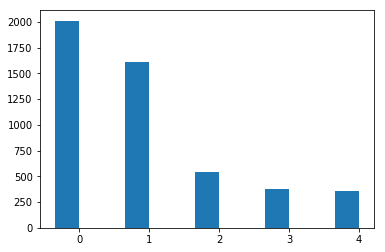

In [112]:
chart_word_diff(freq_diffs, freq_diffs['word'][3:8].values)

In [67]:
count_freq.index

Index(['10', '2016', 'actually', 'america', 'american', 'americans', 'amp',
       'anti', 'attack', 'bad',
       ...
       'white house', 'win', 'woman', 'women', 'won', 'work', 'world', 'wrong',
       'year', 'years'],
      dtype='object', length=187)

In [150]:
sorted_word_count = count_df.sum().sort_values(ascending=False)

In [151]:
sorted_word_count

https       4998560
co          4604796
https co    4589653
trump       3313011
rt          3109453
             ...   
stop          67091
country       66820
russia        66143
rally         65831
last          65817
Length: 89, dtype: int64

In [126]:
len(troll.legit)

2774590

In [ ]:
count_df['legit'] = count_df[count_df[]]

In [ ]:
legit_count = y

### EDA

In [ ]:
# chart word frequencies by class
# chart topics by class 

### LDA

In [26]:
lda = LatentDirichletAllocation(n_components=5, n_jobs=-1, learning_method='online', max_iter=5)

In [27]:
lda.fit(count_df)

LatentDirichletAllocation(learning_method='online', n_components=5, n_jobs=-1)

In [29]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [30]:
num_top_words = 10
display_topics(lda, vocab_count, num_top_words)

Topic 0:
rt realdonaldtrump hillaryclinton don rt hillaryclinton said think want good women
Topic 1:
https rt amp trump election people vote say media white
Topic 2:
https trump rt donald donald trump like new says trump https man
Topic 3:
https rt trump just president america know make did police
Topic 4:
https clinton hillary rt trump hillary clinton obama video time debate


In [39]:
phi = lda.components_ # topic (row) to word (column)

(187,)

In [41]:
theta = lda.transform(count_df) # document (row) to topic (column)

In [45]:
topic_likelihood = np.argmax(theta, axis=1) # returns column index of most likely topic 

In [46]:
topic_likelihood

array([2, 4, 4, ..., 4, 2, 0])

In [51]:
topic_likelihood.shape

(1050000,)

In [42]:
an_array = np.array([[1, 1, 3], [1, 2, 1]])
print(an_array)

max_index_col = np.argmax(an_array, axis=0) # 0 finds column indices
print(max_index_col)

max_index_row = np.argmax(an_array, axis=1) #1 finds row indices
print(max_index_row)

[[1 1 3]
 [1 2 1]]
[0 1 0]
[2 1]


In [61]:
# combine predicted topic with target
topics_by_class = pd.DataFrame({'topic': topic_likelihood, 'legit': y_train.values}) 

In [64]:
# split topic likelihood by class
legit_topics = topics_by_class[topics_by_class['legit'] == 1] 
troll_topics = topics_by_class[topics_by_class['legit'] == 0]

(array([ 69764.,      0.,  58350.,      0.,      0., 206973.,      0.,
         83184.,      0., 106729.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

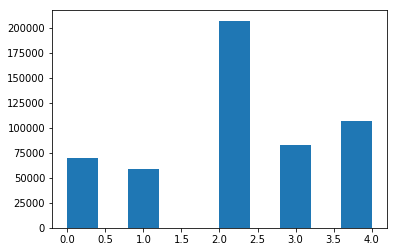

In [65]:
plt.hist(legit_topics['topic'])

(array([ 75127.,      0.,  57635.,      0.,      0., 116964.,      0.,
        240203.,      0.,  35071.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

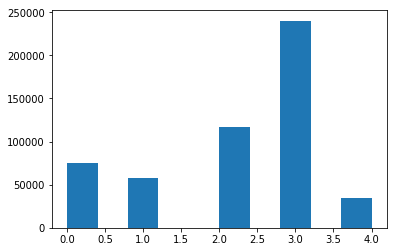

In [66]:
plt.hist(troll_topics['topic'])

In [56]:
len(topic_likelihood)

1050000

In [60]:
len(X_train)

1050000

In [114]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

In [133]:
# lda_model - LatentDirichletAllocation()
# vect - CountVectorizer()
# texts - the list of tokenized words

num_topics = np.arange(2,20,1)
score_array = np.zeros(len(num_topics))
for i,num in enumerate(num_topics):
    model = LatentDirichletAllocation(n_components=num, max_iter=6, learning_method='online', n_jobs=-1)
    model.fit(count_vec)
    metric_coherence_gensim(measure='u_mass', 
                            top_n=25, 
                            topic_word_distrib=model.components_, 
                            dtm=count_df, 
                            vocab=np.array([x for x in vocab_count]), 
                            )
    
    print(num, np.mean(scores))
    score_array[i] = np.mean(scores)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [126]:
count_df.drop('legit', axis=1, inplace=True)

In [128]:
count_df.drop('legt', axis=1, inplace=True)

In [122]:
lda.components_.shape

(5, 187)

In [ ]:
# from sklearn
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
    def plot_top_words(self, n_top_words, title): # from sklearn documentation
        fig, axes = plt.subplots(3, 5, figsize=(30, 25), sharex=True)
        axes = axes.flatten()
        for topic_idx, topic in enumerate(self.model.components_):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [self.feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=40)
        plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
        plt.show();
        plt.savefig('nmf_15.png')